<a href="https://www.kaggle.com/code/oscarfraley/titanic-gradient-boost-classification?scriptVersionId=154741530" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


## Investigate data

In [2]:
train_data = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [3]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
cabin_split = train_data.Cabin.fillna(train_data.Cabin.mode()[0]).apply(lambda x: x.split('/'))
id_split = train_data.PassengerId.apply(lambda x: x.split('_'))
name_split = train_data.Name.fillna('no name').apply(lambda x: x.split(' '))

In [6]:
train_data['CabinDeck'] = cabin_split.apply(lambda x: x[0])
train_data['CabinNum'] = cabin_split.apply(lambda x: float(x[1]))
train_data['CabinSide'] = cabin_split.apply(lambda x: x[2])

In [7]:
numerical_cols = ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age', 'CabinNum']
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']

In [8]:
def plot_numerical_features(numerical_cols, data):
    sns.set(style="whitegrid")
    num_features = len(numerical_cols)
    num_rows = int(np.ceil(num_features / 2))
    num_cols = min(2, num_features)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))

    for i, num in enumerate(numerical_cols):
        if num_rows == 1:
            ax = axes[i]
        else:
            ax = axes[i // num_cols, i % num_cols]
        sns.kdeplot(x=num, hue='Transported', data=data, ax=ax, linewidth=2, alpha=0.7)
        ax.set_title(f'KDE Plot for {num}')
        ax.set_xlabel(num)
        ax.set_ylabel('Density')

    plt.tight_layout()
    plt.show()

def plot_categorical_features(categorical_cols, data): 
    num_features = len(categorical_cols)
    num_rows = int(np.ceil(num_features / 2))
    num_cols = min(2, num_features)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))

    for i, var_name in enumerate(categorical_cols):
        if num_rows == 1:
            ax = axes[i]
        else:
            ax = axes[i // num_cols, i % num_cols]
        sns.countplot(data=data, x=var_name, ax=ax, hue='Transported')
    fig.tight_layout()  
    plt.show()

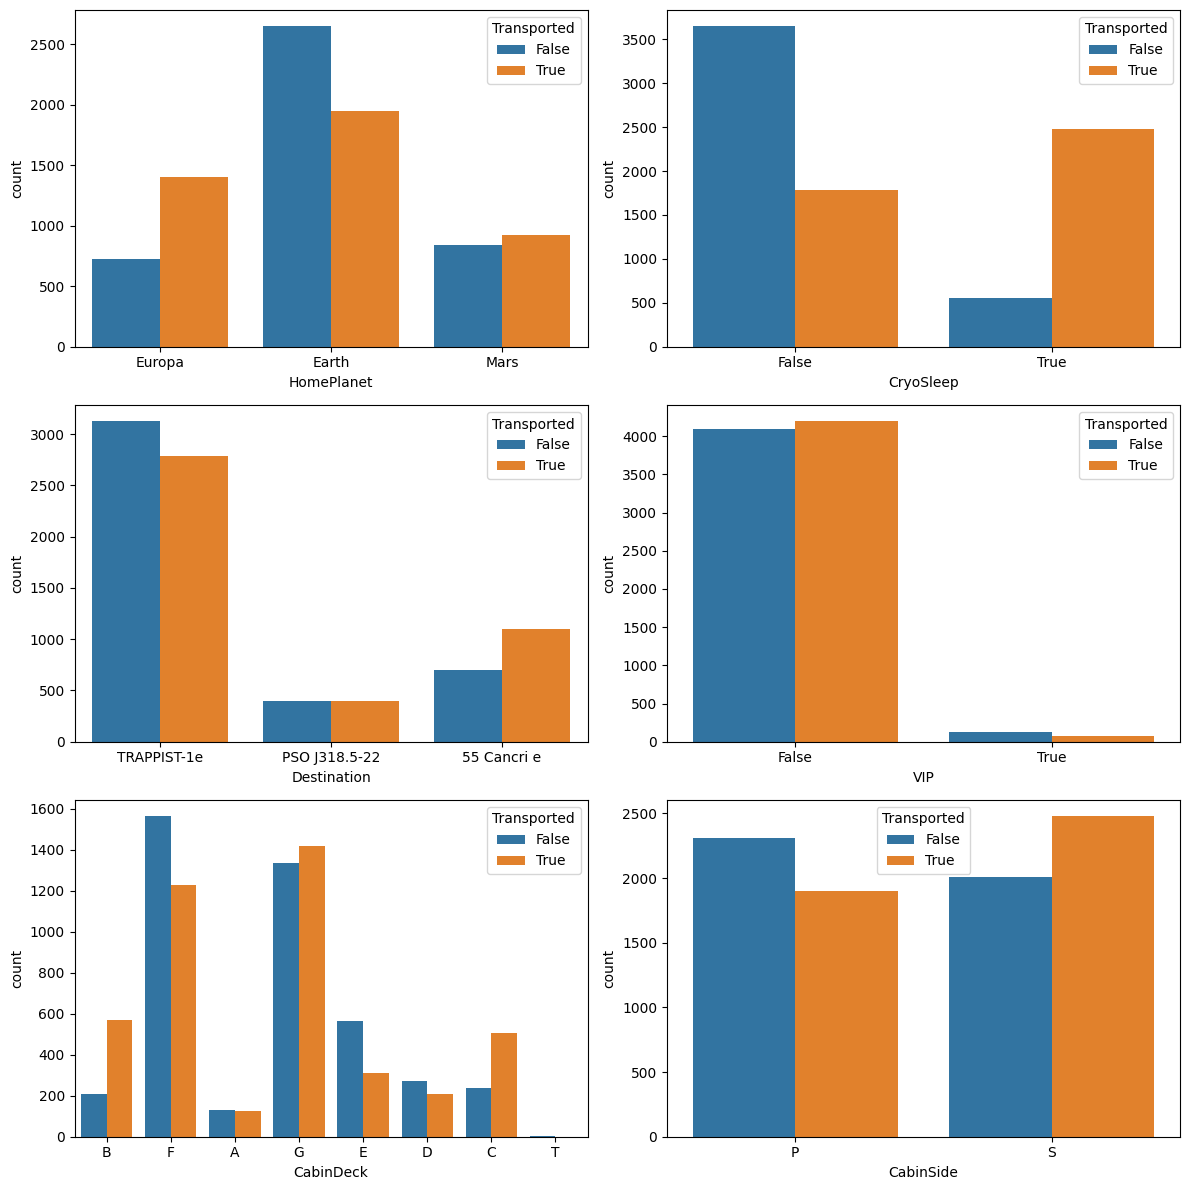

In [9]:
plot_categorical_features(categorical_cols, train_data)

- VIP seems redundant
- Heavy reliance on Cryosleep
- Possible reliance on destination, home planet, and cabin details

In [10]:
train_dat = train_data.copy()

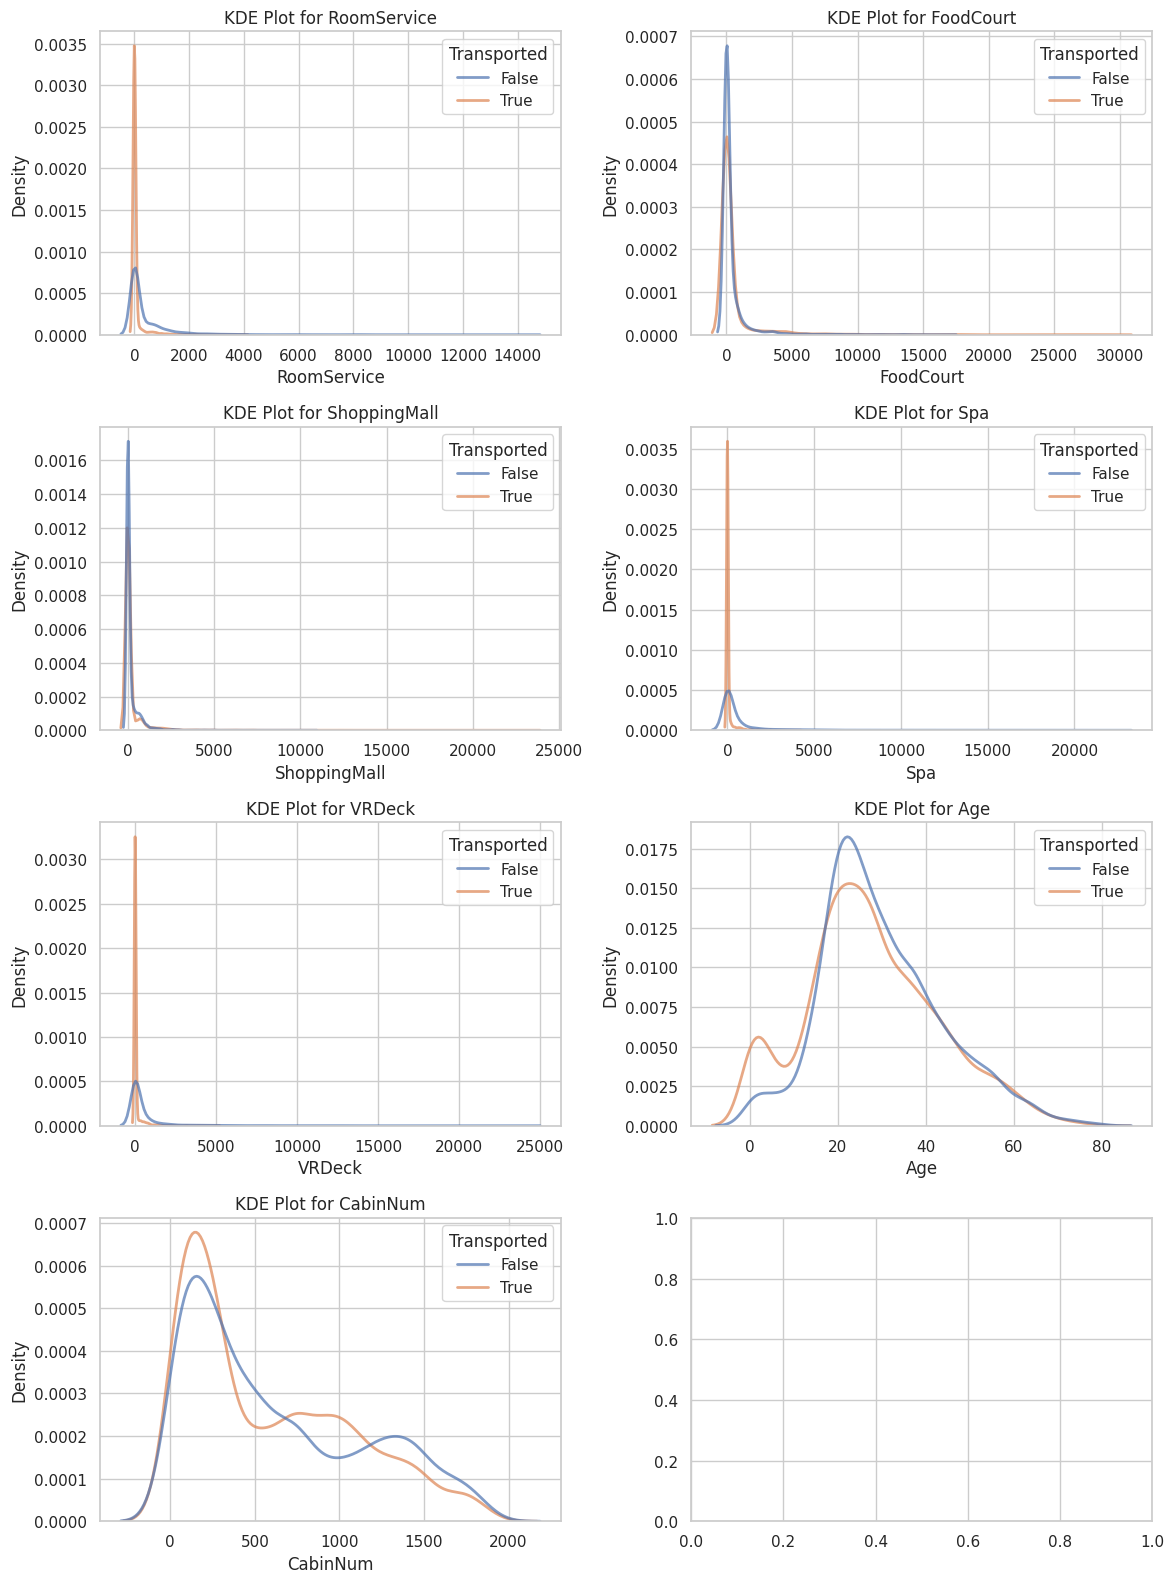

In [11]:
plot_numerical_features(numerical_cols, train_dat)

- Room service, spa and VRDeck very similar distributions
- Shopping mall and food court have similar distributions (close together on spaceship?)
- Age range seems to impact target: babies, children, young adults, adults
- Possible reliance on cabin number but need to investigate further

## Feature Engineer

In [12]:
def add_features(data):
    data['TotalSpent1'] = data['RoomService'] + data['Spa'] + data['VRDeck']
    data['TotalSpent2'] = data['ShoppingMall'] + data['FoodCourt']
    data['AgeGroup'] = data['Age'].apply(lambda x: 'Baby' if x < 5 else 'Child' if x < 18 else('YoungAdult' if x>18 and x < 40 else 'MatureAdult'))
    data['CabinCombination'] = data['CabinSide'] + data['CabinDeck']
    data['GroupID'] = id_split.str[0]
    data['GroupSize'] = data['GroupID'].map(data['GroupID'].value_counts())
    data['Companions'] = data['GroupSize'].apply(lambda x: 'Alone' if x==1 else 'Group')
    return data

In [13]:
updated_train_data = add_features(train_dat)

In [14]:
#train_data.loc[(train_data['Companions'] == 'Group') & (train_data['FamilySize'] == train_data['GroupSize']) & (train_data['FamilySize']<3), 'Companions'] = 'SmallFamily'
#train_data.loc[(train_data['Companions'] == 'Group') & (train_data['FamilySize'] == train_data['GroupSize']) & ((train_data['FamilySize']>=3) & (train_data['FamilySize']<5)), 'Companions'] = 'LargeFamily'
#train_data.loc[((train_data['Companions'] == 'Group') & (train_data['GroupSize'] < 3)),'Companions'] = 'SmallGroup'
#train_data.loc[((train_data['Companions'] == 'Group') & (train_data['GroupSize'] >= 3)),'Companions'] = 'LargeGroup'

In [15]:
updated_numerical_cols = ['TotalSpent1', 'TotalSpent2']
updated_categorical_cols = ['AgeGroup','HomePlanet','CryoSleep','CabinSide', 'CabinDeck']

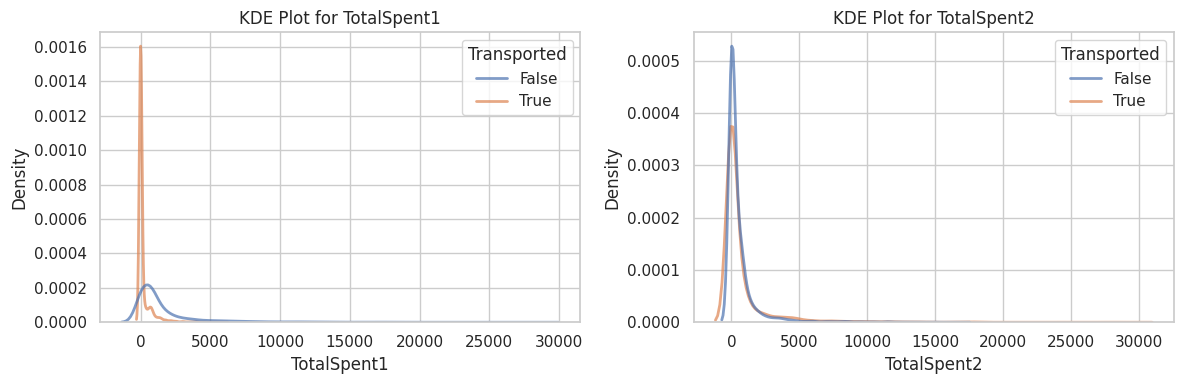

In [16]:
plot_numerical_features(updated_numerical_cols, updated_train_data)

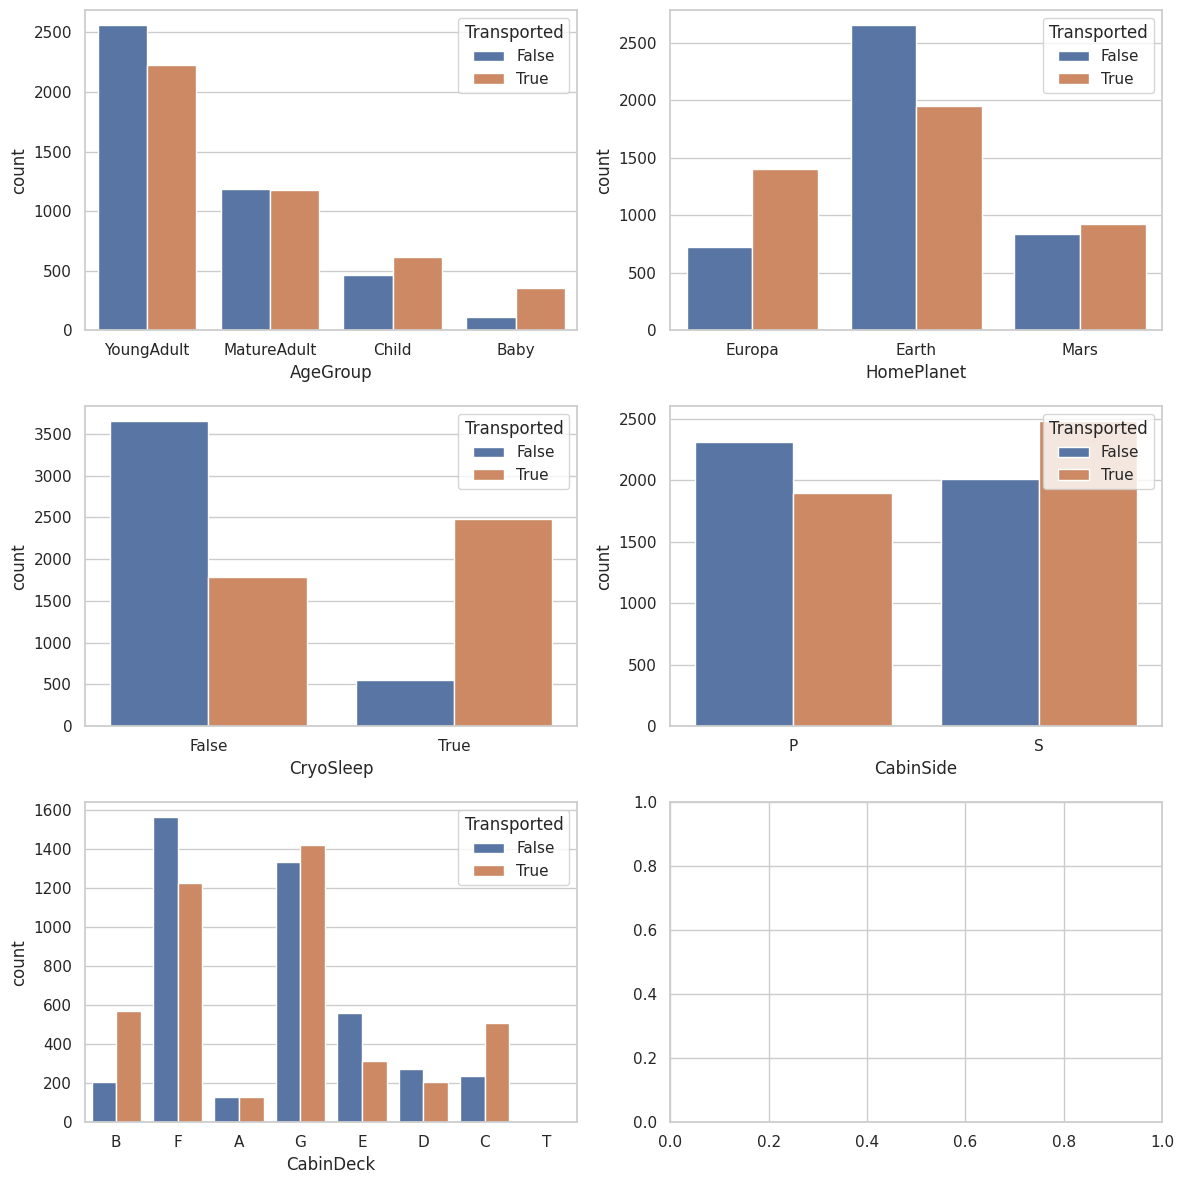

In [17]:
plot_categorical_features(updated_categorical_cols, updated_train_data)

## Create Pipeline

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler

In [19]:
def create_pipeline(transformer, model, num_cols, cat_cols):
    
    numerical_transformer = Pipeline(steps= [
        ('imputer',SimpleImputer(strategy='median')),
        ('transformer', transformer)])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])

    preprocessor = ColumnTransformer(
        transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)])
    
    return pipe

In [20]:
features = list(np.concatenate([updated_categorical_cols, updated_numerical_cols]))
features.append('Transported')

In [21]:
X = updated_train_data.copy()[features]
y = X.pop('Transported')

## Investigate models

In [22]:
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

In [23]:
models = [XGBClassifier(), LGBMClassifier()]

In [24]:
transformers = [None, PowerTransformer(), StandardScaler()]

In [25]:
best_score = 0
for i, model in enumerate(models):
    for j, transformer in enumerate(transformers):
        score = cross_val_score(create_pipeline(transformer, model, updated_numerical_cols, updated_categorical_cols), X, y, cv=8, scoring='accuracy').mean()
        if score > best_score:
            best_score = score 
            best_model = create_pipeline(transformer, model, updated_numerical_cols, updated_categorical_cols)
        print(f'Model: {i} and Transformer: {j}, Cross Val Score: {score}')

Model: 0 and Transformer: 0, Cross Val Score: 0.803522840670167
Model: 0 and Transformer: 1, Cross Val Score: 0.803522840670167
Model: 0 and Transformer: 2, Cross Val Score: 0.803522840670167
Model: 1 and Transformer: 0, Cross Val Score: 0.802831915268509
Model: 1 and Transformer: 1, Cross Val Score: 0.8024873526237587
Model: 1 and Transformer: 2, Cross Val Score: 0.8023726748904261


In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state =2)

In [27]:
best_model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('transformer',
                                                                   None)]),
                                                  ['TotalSpent1',
                                                   'TotalSpent2']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['AgeGroup', 'HomePla...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [28]:
accuracy_score(best_model.predict(x_test), y_test)

0.8081876724931003

## Create Predictions

In [29]:
cabin_split = test_data.Cabin.fillna(test_data.Cabin.mode()[0]).apply(lambda x: x.split('/'))
id_split = test_data.PassengerId.apply(lambda x: x.split('_'))
name_split = test_data.Name.fillna('no name').apply(lambda x: x.split(' '))

In [30]:
test_data['CabinDeck'] = cabin_split.apply(lambda x: x[0])
test_data['CabinNum'] = cabin_split.apply(lambda x: float(x[1]))
test_data['CabinSide'] = cabin_split.apply(lambda x: x[2])

In [31]:
updated_test_data = add_features(test_data)

In [32]:
best_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('transformer',
                                                                   None)]),
                                                  ['TotalSpent1',
                                                   'TotalSpent2']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['AgeGroup', 'HomePla...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [33]:
submission = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Transported': best_model.predict(test_data)})
submission.to_csv('submission.csv', index=False)